In [31]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from scipy.ndimage import binary_dilation, binary_erosion
from skimage.morphology import disk
import random

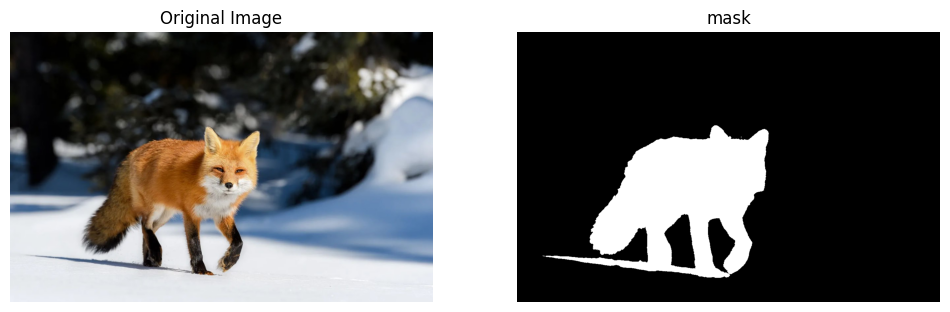

In [32]:
# Load the images
image_path = "fox.jpeg"
mask_path = "mask.png"

image = Image.open(image_path).convert("RGB")
mask = Image.open(mask_path).convert("L")

image_array = np.array(image)
mask_array = np.array(mask)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image_array)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("mask")
plt.imshow(mask_array, cmap="gray")
plt.axis("off")
plt.show()

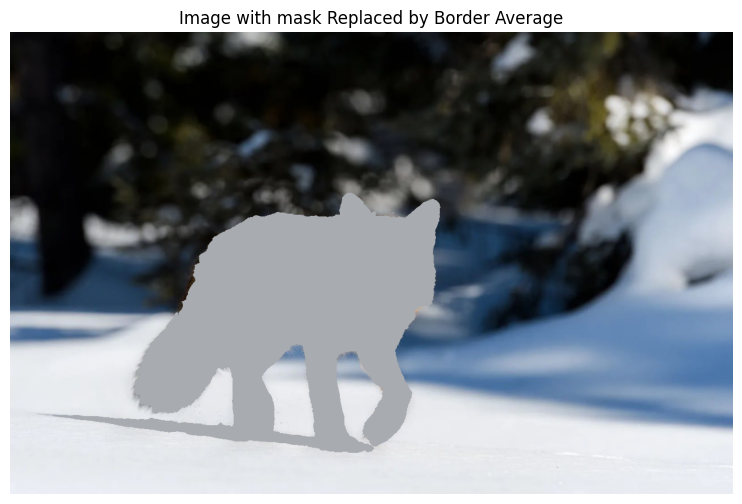

In [33]:
# Method 1: Fill with Average
def fill_with_average(image, mask):
    border_mask = binary_dilation(mask > 0) & ~(mask > 0)
    border_pixels = image[border_mask]
    if len(border_pixels) > 0:
        border_mean = np.mean(border_pixels, axis=0)
    else:
        border_mean = np.array([0, 0, 0])
    replaced_image = image.copy()
    replaced_image[mask > 0] = border_mean
    return replaced_image

border_replaced_image = fill_with_average(image_array, mask_array)
plt.figure(figsize=(10, 6))
plt.title("Image with mask Replaced by Border Average")
plt.imshow(border_replaced_image.astype(np.uint8))
plt.axis("off")
plt.show()

Streaming output truncated to the last 5000 lines.
<ipython-input-27-959dbef19133>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filled_image[r, c, channel] = model.predict(np.array([[c]]))
<ipython-input-27-959dbef19133>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filled_image[r, c, channel] = model.predict(np.array([[c]]))
<ipython-input-27-959dbef19133>:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  filled_image[r, c, channel] = model.predict(np.arr

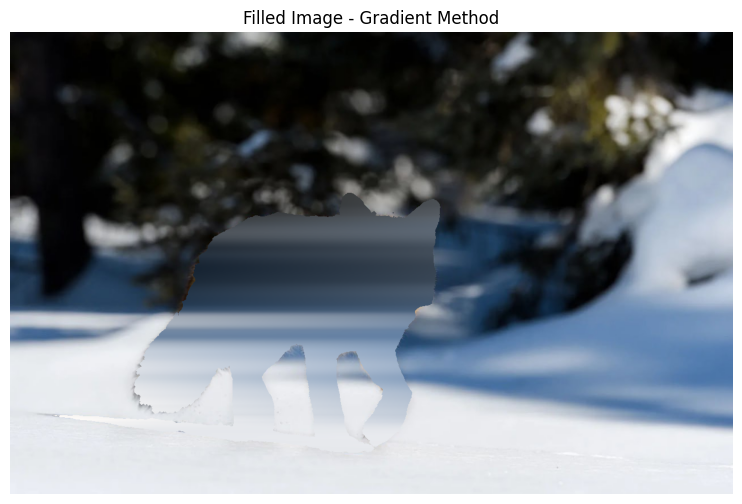

In [27]:
# Method 2: Fill with Gradient
def fill_with_gradient(image, mask):
    filled_image = image.copy()
    rows, cols, channels = image.shape
    for r in range(rows):
        x_known = []
        y_known = []
        for c in range(cols):
            if mask[r, c] == 0:  # Outside the mask
                x_known.append(c)
                y_known.append(image[r, c])
        if len(x_known) > 1:
            x_known = np.array(x_known).reshape(-1, 1)
            for channel in range(channels):
                model = LinearRegression()
                y_channel = np.array([pix[channel] for pix in y_known])
                model.fit(x_known, y_channel)
                for c in range(cols):
                    if mask[r, c] > 0:  # Inside the mask
                        filled_image[r, c, channel] = model.predict(np.array([[c]]))
    return filled_image

gradient_filled_image = fill_with_gradient(image_array, mask_array)
plt.figure(figsize=(10, 6))
plt.title("Filled Image - Gradient Method")
plt.imshow(gradient_filled_image.astype(np.uint8))
plt.axis("off")
plt.show()

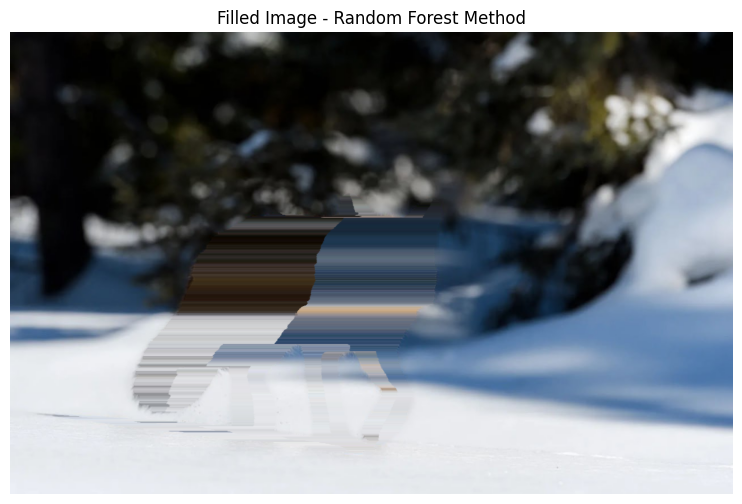

In [28]:
# Method 3: Fill with Machine Learning (Random Forest)
def fill_with_ml(image, mask):
    filled_image = image.copy()
    rows, cols, channels = image.shape
    for r in range(rows):
        x_train, y_train = [], []
        x_test = []
        for c in range(cols):
            if mask[r, c] == 0:  # Known pixel
                x_train.append([c])
                y_train.append(image[r, c])
            elif mask[r, c] > 0:  # Masked pixel
                x_test.append([c])
        if len(x_train) > 1 and len(x_test) > 0:
            x_train = np.array(x_train)
            x_test = np.array(x_test)
            for channel in range(channels):
                y_train_channel = np.array([pix[channel] for pix in y_train])
                model = RandomForestRegressor(n_estimators=10, random_state=42)
                model.fit(x_train, y_train_channel)
                predictions = model.predict(x_test)
                for i, c in enumerate(x_test):
                    filled_image[r, c[0], channel] = predictions[i]
    return filled_image

ml_filled_image = fill_with_ml(image_array, mask_array)
plt.figure(figsize=(10, 6))
plt.title("Filled Image - Random Forest Method")
plt.imshow(ml_filled_image.astype(np.uint8))
plt.axis("off")
plt.show()

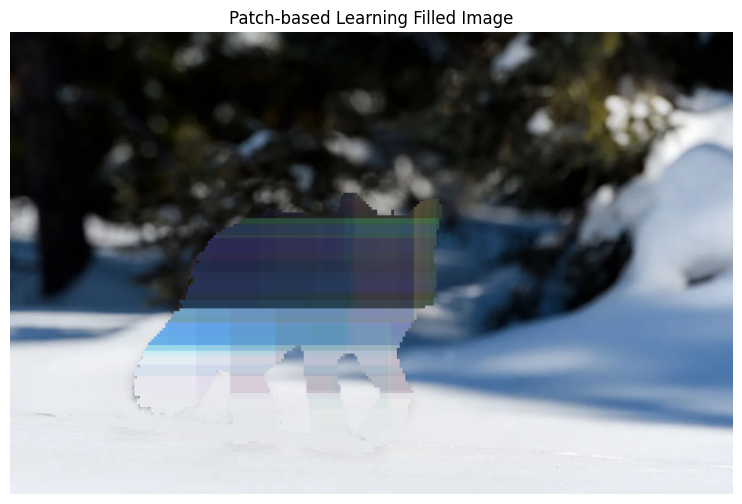

In [29]:
# Method 4: Patch-based Learning with Random Forest
def patch_based_learning(image, mask, patch_size=5, num_samples=100):
    filled_image = image.copy()
    rows, cols, channels = image.shape
    x_train, y_train = [], []
    for _ in range(num_samples):
        r = random.randint(0, rows - patch_size)
        c = random.randint(0, cols - patch_size)
        patch_mask = mask[r:r+patch_size, c:c+patch_size]
        if np.all(patch_mask == 0):
            patch = image[r:r+patch_size, c:c+patch_size]
            x_train.append([r, c])
            y_train.append(np.mean(patch, axis=(0, 1)))
    models = []
    for channel in range(channels):
        y_train_channel = np.array([target[channel] for target in y_train])
        model = RandomForestRegressor(n_estimators=10, random_state=42)
        model.fit(x_train, y_train_channel)
        models.append(model)
    for r in range(0, rows, patch_size):
        for c in range(0, cols, patch_size):
            patch_mask = mask[r:r+patch_size, c:c+patch_size]
            if np.any(patch_mask > 0):
                predicted_patch = np.zeros((patch_size, patch_size, channels))
                for channel in range(channels):
                    mean_color = models[channel].predict([[r, c]])
                    predicted_patch[:, :, channel] = mean_color
                filled_image[r:r+patch_size, c:c+patch_size] = predicted_patch
    return filled_image

patch_learning_filled_image = patch_based_learning(image_array, mask_array, patch_size=5, num_samples=200)
plt.figure(figsize=(10, 6))
plt.title("Patch-based Learning Filled Image")
plt.imshow(patch_learning_filled_image.astype(np.uint8))
plt.axis("off")
plt.show()

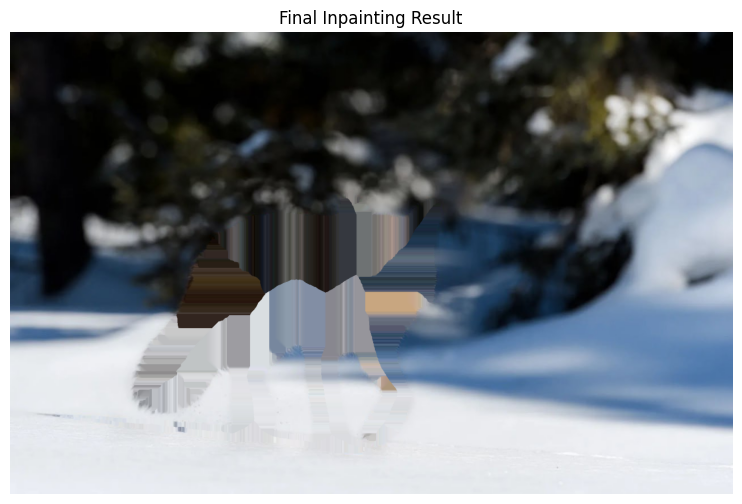

In [30]:
# Method 5: Iterative Erosion
def iterative_erosion(image, mask):
    inpainted_image = image.copy()
    current_mask = mask.copy()
    iteration = 0
    while np.any(current_mask):  # Continue until the mask is fully eroded
        iteration += 1
        border_mask = current_mask & ~binary_erosion(current_mask, structure=disk(1))
        updated_image = inpainted_image.copy()
        for r in range(image.shape[0]):
            for c in range(image.shape[1]):
                if border_mask[r, c]:
                    neighbors = []
                    if r > 0 and not current_mask[r - 1, c]:  # Top neighbor
                        neighbors.append(inpainted_image[r - 1, c])
                    if r < image.shape[0] - 1 and not current_mask[r + 1, c]:  # Bottom neighbor
                        neighbors.append(inpainted_image[r + 1, c])
                    if c > 0 and not current_mask[r, c - 1]:  # Left neighbor
                        neighbors.append(inpainted_image[r, c - 1])
                    if c < image.shape[1] - 1 and not current_mask[r, c + 1]:  # Right neighbor
                        neighbors.append(inpainted_image[r, c + 1])
                    if neighbors:
                        updated_image[r, c] = np.mean(neighbors, axis=0)
        inpainted_image = updated_image
        current_mask = binary_erosion(current_mask, structure=disk(1)).astype(mask.dtype)
    return inpainted_image

final_inpainted_image = iterative_erosion(image_array, mask_array)
plt.figure(figsize=(10, 6))
plt.title("Final Inpainting Result")
plt.imshow(final_inpainted_image.astype(np.uint8))
plt.axis("off")
plt.show()